# Amazon Reviews for Sentiment Analysis



#  Project 3 : Amazon reviews analysis. 
This dataset consists of a few million Amazon customer reviews (input text) and star
ratings (output labels) for learning how to train fastText for sentiment analysis.

## Importing Packages

In [2]:
import pandas as pd
import numpy as np
import random

import os
import gc
from PIL import Image
from textwrap import wrap
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

from tensorflow.python.keras import models, layers, optimizers
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers import GlobalMaxPooling1D
from keras.layers.core import Activation, Dropout, Dense
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
import bz2
import re

%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['amazonreviews']


In [3]:
!pip install transformers

In [4]:
import transformers
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification

In [5]:
tf.random.set_seed(18)
np.random.seed(18)

## Pre-processing

### Reading the text

We extract label and text from the compressed format, converting the label to a number.

In [7]:
def get_labels_and_texts(file):
    labels = []
    texts = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        texts.append(x[10:].strip())
    labels = labels[:int(len(labels)*0.01)]
    texts = texts[:int(len(texts)*0.01)]
    return np.array(labels), texts
train_labels, train_texts = get_labels_and_texts('/kaggle/input/amazonreviews/train.ft.txt.bz2')
test_labels, test_texts = get_labels_and_texts('/kaggle/input/amazonreviews/test.ft.txt.bz2')

We normalize the text, by converting everything to lowercase everything and then remove non-word characters. We also replace these with spaces since most are going to be punctuation. Finally, we remove any other characters (e.g. letters with accents).

In [8]:
train_texts[0]

'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [9]:
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = []
    for text in texts:
        lower = text.lower()
        no_punctuation = NON_ALPHANUM.sub(r' ', lower)
        no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
        normalized_texts.append(no_non_ascii)
    return normalized_texts
        
train_texts = normalize_texts(train_texts)
test_texts = normalize_texts(test_texts)

In [10]:
train_texts[0]

'stuning even for the non gamer  this sound track was beautiful  it paints the senery in your mind so well i would recomend it even to people who hate vid  game music  i have played the game chrono cross but out of all of the games i have ever played it has the best music  it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras  it would impress anyone who cares to listen    '

In [11]:
len(test_texts)

4000

In [12]:
len(train_texts)

36000

In [13]:
#Copy for BERT and word cloud
train_texts_Bert = train_texts
train_labels_Bert = train_labels
test_texts_Bert = test_texts
test_labels_Bert = test_labels
train_reviews = train_texts

## Exploratory Data Analysis

First we plot the label distribution in both training and test set

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


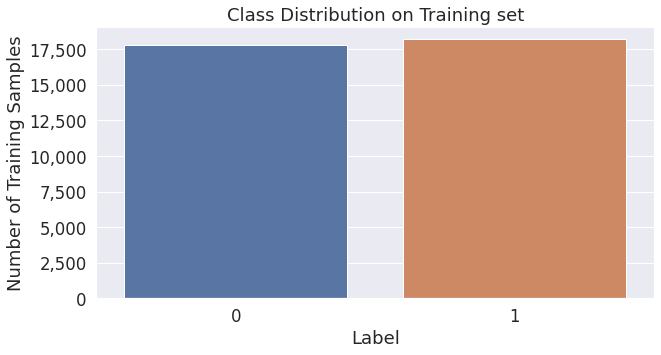

In [14]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

#Plot the number of tokens of each length.
ax = sns.countplot(train_labels)

plt.title('Class Distribution on Training set')
plt.xlabel('Label')
plt.ylabel('Number of Training Samples')

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


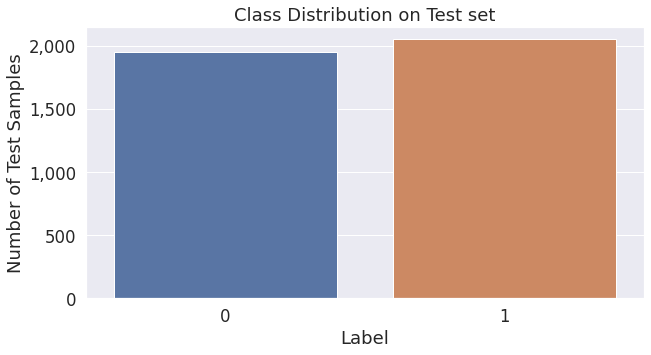

In [15]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

#Plot the number of tokens of each length.
ax = sns.countplot(test_labels)


plt.title('Class Distribution on Test set')
plt.xlabel('Label')
plt.ylabel('Number of Test Samples')

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

As we can see both are fairly balanced, which will help our models to not be biased.

### Word Cloud 

An additional EDA we can perform is to generate a world cloud based on reviews from the train dataset. This could give us an idea of the most used words in the reviews. In order to produce the word cloud we perform the following operation on the text reviews:
1. Lemmatization: This is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. Similarly job is done with stemming, however, Lemmatization is preferred since it morphologically analysis each word, while stemming simply uses the stem of a word which may lead to words (e.g. 'caring' would be 'car').
1. Stop words removal: Then we can remove stop words, which are those words that occur commonly across all the documents in the corpus. Typically, articles and pronouns are generally classified as stop words. To these, we also add 'would' and 'like' which could also be commonly used in a review with different meaning.
1. Tokenization: Which will convert the input text into a list of tokens to feed the TfidfVectorizer.
1. Vectorization using TF-IDF: We vectorize the input by using TF-IDF, which stands for Term Frequency and Inverse Document Frequency. TF gives us information on how often a term appears in a document, while, IDF gives us information about the relative rarity of a term in the collection of documents. The TF-IDF score will tell how important a word is in the collection, with the least important being 0. TfidfVectorizer was used, with ngram range of 1, meaning each word is taken separately.

In [16]:
stop = stopwords.words('english') + ['would', 'like']

In [17]:
def remove_encoding_word(word):
    word = str(word)
    word = word.encode('ASCII', 'ignore').decode('ASCII')
    return word

def remove_encoding_text(text):
    text = str(text)
    text = ' '.join(remove_encoding_word(word) for word in text.split() if word not in stop)
    return text

In [18]:
train_reviews = remove_encoding_text(train_reviews)
text = ' '.join(words for words in train_reviews)
lemma = WordNetLemmatizer().lemmatize

In [19]:
def tokenize(document):
    tokens = [lemma(w) for w in document.split() if len(w) > 3 and w.isalpha()]
    return tokens

In [ ]:
#import nltk
#nltk.download('omw-1.4')

#nltk.download('omw')
#!pip install --upgrade nltk

!pip install numpy
!pip install networkx
!pip install nose
!pip install scipy
!pip install gensim
!pip install six
!pip install tqdm
!pip install pyyaml
!pip install requests
!pip install joblib
!pip install sklearn

import nltk
nltk.download('omw-1.4')

In [30]:
vectorizer = TfidfVectorizer(tokenizer = tokenize, ngram_range = ((1,1)), stop_words = stop, strip_accents = 'unicode')
train_reviews = [train_reviews]
tdm = vectorizer.fit_transform(train_reviews)

AttributeError: 'list' object has no attribute 'lower'

In [ ]:
#Weights for word cloud
tfidf_weigths = [(word, tdm.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]

In [ ]:
tfidf_weigths[0:10]

In [ ]:
w = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=2000).fit_words(dict(tfidf_weigths))

plt.figure(figsize=(20,15))
plt.imshow(w)
plt.axis('off')

## Data Preparation

#### Train/Validation Split
We split the dataset, keeping 20% of the training set for validation.

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, random_state=57643892, test_size=0.2)

In order to convert texts to formats that are readable by Deep Learning models, we used Keras tools:

We tokenized the text, converting each each sentence of each review in understandable bits of data, during this step, in order to have inputs of similar lengths, we decided to keep 12000 words based on word frequency.
In addition, to have sequences of same length we added a padding to make every everything the same length, this was set to the length of the longest text.

In [ ]:
MAX_FEATURES = 12000
#Tokenize texts
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_texts)
train_texts = tokenizer.texts_to_sequences(train_texts)
val_texts = tokenizer.texts_to_sequences(val_texts)
test_texts = tokenizer.texts_to_sequences(test_texts)


In [ ]:
print(train_texts[0])

In [ ]:
MAX_LENGTH = max(len(train_ex) for train_ex in train_texts)
#Add padding
train_texts = pad_sequences(train_texts, maxlen=MAX_LENGTH)
val_texts = pad_sequences(val_texts, maxlen=MAX_LENGTH)
test_texts = pad_sequences(test_texts, maxlen=MAX_LENGTH)

In [ ]:
train_texts[0]

## Models

### Convolutional Neural Network (CNN)

Since text data is one-dimensional, we can use 1D convolutional neural networks to extract features from our data. We create a very simple CNN model by creating an Embedding layer and directly connect it to a Convolution layer and a pooling layer to reduce feature size. Finally, a dense layer with sigmoid activation.

In [ ]:
def build_cnn_model():
    model = Sequential()
    embedding_layer = Embedding(MAX_FEATURES, 64)
    model.add(embedding_layer)
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model
    
cnn_model = build_cnn_model()

In [ ]:
print(cnn_model.summary())

In [ ]:
cnn_model.fit(
    train_texts, 
    train_labels, 
    batch_size=128,
    epochs=2,
    validation_data=(val_texts, val_labels), )

In [ ]:
preds = cnn_model.predict(test_texts)
print('Accuracy score: {:0.4}'.format(accuracy_score(test_labels, 1 * (preds > 0.5))))
print('F1 score: {:0.4}'.format(f1_score(test_labels, 1 * (preds > 0.5))))
print('ROC AUC score: {:0.4}'.format(roc_auc_score(test_labels, preds)))

### Recurrent Neural Network (RNN)

For an RNN model we also use a simple model This has an embedding, two GRU layers, followed by 2 dense layers and then the output layer. CuDNNGRU is used as it performs faster.

In [ ]:
def build_rnn_model():
    sequences = layers.Input(shape=(MAX_LENGTH,))
    embedded = layers.Embedding(MAX_FEATURES, 64)(sequences)
    x = layers.CuDNNGRU(128, return_sequences=True)(embedded)
    x = layers.CuDNNGRU(128)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model
    
rnn_model = build_rnn_model()

In [ ]:
print(rnn_model.summary())

In [ ]:
rnn_model.fit(
    train_texts, 
    train_labels, 
    batch_size=128,
    epochs=1,
    validation_data=(val_texts, val_labels), )

In [ ]:
preds = rnn_model.predict(test_texts)
print('Accuracy score: {:0.4}'.format(accuracy_score(test_labels, 1 * (preds > 0.5))))
print('F1 score: {:0.4}'.format(f1_score(test_labels, 1 * (preds > 0.5))))
print('ROC AUC score: {:0.4}'.format(roc_auc_score(test_labels, preds)))

### Long Short-Term Memory (LSTM)

In [ ]:
def build_lstm_model():
    sequences = layers.Input(shape=(MAX_LENGTH,))
    embedded = layers.Embedding(MAX_FEATURES, 64)(sequences)
    x = layers.LSTM(32, return_sequences=True)(embedded)
    x = layers.GlobalMaxPool1D()(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model
    
lstm_model = build_lstm_model()

In [ ]:
print(lstm_model.summary())

In [ ]:
lstm_model.fit(
    train_texts, 
    train_labels, 
    batch_size=128,
    epochs=2,
    validation_data=(val_texts, val_labels), )

In [ ]:
preds = lstm_model.predict(test_texts)
print('Accuracy score: {:0.4}'.format(accuracy_score(test_labels, 1 * (preds > 0.5))))
print('F1 score: {:0.4}'.format(f1_score(test_labels, 1 * (preds > 0.5))))
print('ROC AUC score: {:0.4}'.format(roc_auc_score(test_labels, preds)))

### BERT

For BERT we do same split on train set (20% for validation)

In [ ]:
train_texts_Bert, val_texts_Bert, train_labels_Bert, val_labels_Bert = train_test_split(
    train_texts_Bert, train_labels_Bert, random_state=57643892, test_size=0.2)

In [ ]:
#Assign tokenizer object to the tokenizer class
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
train_encodings = tokenizer(train_texts_Bert,
                            truncation=True,
                            padding=True,
                            max_length=256)
val_encodings = tokenizer(val_texts_Bert,
                          truncation=True,
                          padding=True,
                          max_length=256)
train_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(train_encodings),
                            train_labels_Bert
                            ))
val_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(val_encodings),
                            val_labels_Bert
                            ))
test_encodings = tokenizer(test_texts_Bert,
                          truncation=True,
                          padding=True,
                          max_length=256)
test_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(test_encodings),
                            test_labels_Bert
                            ))

In [ ]:
train_texts_Bert[0]

In [ ]:
print(tokenizer.batch_decode(train_encodings["input_ids"][0]))

In [ ]:
print(train_encodings["input_ids"][0])

In [ ]:
print(train_encodings["attention_mask"][0])

In [ ]:
test_dataset

In [ ]:
bert_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=2)

In [ ]:
print(bert_model.summary())

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
bert_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["binary_accuracy"])
bert_model.fit(train_dataset.shuffle(100).batch(16),
          epochs=2,
          batch_size=16,
          validation_data=val_dataset.shuffle(100).batch(16))

In [ ]:
results_bert = bert_model.evaluate(test_dataset.batch(8))

#### Results

Results obtained in different runs, due to undeterministic behaviour of models:
* Bert 90%, 88%, 91%, 90%